project name: flexpart_management
created by diego aliaga daliaga_at_chacaltaya.edu.bo

imports

In [27]:

from useful_scit.imps import *
# noinspection PyUnresolvedReferences
import matplotlib.colors
import flexpart_management.modules.FlexLogPol as FlexLogPol
import flexpart_management.modules.constants as co
# noinspection PyUnresolvedReferences
import flexpart_management.modules.flx_array as fa
import flexpart_management.modules.clustering_funs as cfuns

In [28]:
from sklearn.cluster import KMeans

import flexpart_management.modules.clustering_funs as cfuns

co.LAB = 'lab'


def re_cluster( _df , nc , df_labs ) :
    k_means = KMeans( n_clusters=nc , random_state=0 )
    labs = k_means.fit_predict( _df )
    print( labs.shape )
    df_labs[ nc ] = labs


def get_lab_ds_current_i( * , meta_cluster_i , current_i ,
                          df_labs , ds_re_lab , ds_sum ) :
    clus_bool = (df_labs[ meta_cluster_i ] == current_i)
    list_labs = df_labs[ clus_bool ].index.values
    print( list_labs )
    _bool = ds_sum[ co.LAB ].isin( list_labs )
    ds_re_lab[ co.LAB ] = ds_re_lab[ co.LAB ].where( ~_bool , current_i )
    # return _bool


def get_re_lab_ds( * , ds , ds_sum , df_labs , meta_cluster_i , ) :
    # noinspection PyShadowingNames
    ds_re_lab = ds.copy()
    # noinspection PyShadowingNames
    for current_i in range( meta_cluster_i ) :
        get_lab_ds_current_i(
            meta_cluster_i=meta_cluster_i ,
            current_i=current_i ,
            df_labs=df_labs ,
            ds_sum=ds_sum ,
            ds_re_lab=ds_re_lab ,
            )
    return ds_re_lab


# def main() :

In [29]:

plt.rcParams[ 'figure.facecolor' ] = 'white'

In [30]:

log.ger.setLevel( log.log.DEBUG )

In [31]:
# noinspection PyUnusedLocal,PyShadowingNames
def open_if_taito() :
    # noinspection SpellCheckingInspection
    path = \
        '/homeappl/home/aliagadi/wrk/DONOTREMOVE' \
        '/flexpart_management_data/runs/' \
        'run_2019-10-02_13-42-52_/' \
        'log_pol/run_2019-10-02_13-42-52_'
    # flp = FLP.FlexLogPol(path,concat=True)
    # flp_instance = FLP.FlexLogPol(path,concat=False)
    selfFLP = FlexLogPol.FlexLogPol(
        path ,
        # concat=True,
        concat=False ,
        get_clusters=False ,
        # open_merged=False,
        open_merged=True ,
        # merge_ds=False ,
        # merge_ds=True ,
        clusters_avail=False ,

        # postprocess set to false since we are opening the re interpolated
        # version
        postprocess=False ,

        use_new_merge_fun=True ,

        # set to false bc already done in the saved version
        filter_r_min_max=False ,
        )
    selfFLP.get_list_datasets_saved()
    # noinspection PyUnresolvedReferences
    ds = selfFLP.open_ds_version( 'ds_clustered_18.nc' )
    return selfFLP , ds

def get_ds_re_lab_title( current_i , df_labs , meta_cluster_i ) :
    _b = df_labs[ meta_cluster_i ] == current_i
    clust_labs_str = str( df_labs[ meta_cluster_i ][ _b ].index.values )
    title = f'c:{current_i}/{meta_cluster_i} | {clust_labs_str}'
    return title

In [32]:
# selfFLP,ds = open_if_taito()
path = '/Users/diego/flexpart_management/flexpart_management/tmp_data' \
       '/ds_clustered_18.nc'
ds = xr.open_dataset( path )

conc_lab = 'CONC_smooth_t_300_z_25_r_100_th_50'
new_lab_p = 'conc_smooth_p'
new_lab_p_t = 'conc_smooth_p_t'
cfuns.add_total_per_row( ds , conc_lab , new_lab_p )
cfuns.add_time_per_row( ds , conc_lab , new_lab_p_t )

In [33]:
# ds = re_interpolate_merged_processed_ds_and_save( selfFLP )

In [34]:
# ds_small = ds[{co.RL:slice(None,None,100)}]

 # %%
ds = ds.transpose( 'R_CENTER' , 'TH_CENTER' , 'ZMID' , 'releases' )
ds = ds.assign_coords( **{ co.LAB : ds[ co.LAB ] } )

In [35]:
# df = ds[new_lab_p].to_dataframe()

In [36]:
ds_trimmed = ds[ new_lab_p ].reset_coords()[ [ new_lab_p , co.LAB ] ]
df: pd.DataFrame = ds_trimmed.to_dataframe()

In [37]:
cols = list( df.columns )
df_trimmed = df.reset_index()[ [ *cols , co.RL ] ]

In [38]:

df_g = df_trimmed.groupby( [ co.LAB , co.RL ] )

In [39]:
df_s = df_g.sum()

In [40]:
da_lab = df_s.to_xarray()[ new_lab_p ].transpose( co.LAB , co.RL )

In [41]:
data = da_lab.data
# noinspection PyStatementEffect
data.shape

(18, 4248)

In [42]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()
data_transformed = scaler.fit_transform( data.T ).T

In [ ]:
vector = data_transformed[ 2 ]
print( vector.shape )
# sns.distplot( vector )

# plt.show()

In [44]:
da_lab_transformed = da_lab.copy()
da_lab_transformed.data = data_transformed

In [ ]:
# da_lab_transformed.plot( cmap=plt.get_cmap( 'Reds' ) )
# plt.show()

In [ ]:
_df: pd.DataFrame = da_lab_transformed.transpose( co.RL ,
                                                  co.LAB ).to_dataframe()
_df = _df.unstack( 0 ).iloc[ : , : ]
print( _df )
# _df.T.plot.scatter( x=9 , y=10 , alpha=.1 , s=100 )
# plt.show()

In [47]:
meta_cluster_list = [ 2 , 4 , 6 , 8 ]
df_labs = pd.DataFrame( [ ] , _df.index )
df_labs.columns.name = 'num_clus'
for i in meta_cluster_list :
    re_cluster( _df , i , df_labs=df_labs )

(18,)
(18,)
(18,)
(18,)


In [48]:
ds_sum = ds[ new_lab_p ].sum( co.RL )

In [49]:
# meta_cluster_i = 4
# current_i = 3

[ 0  1  3  4  6  9 12 15 16 17]
[ 2  5  7  8 10 11 13 14]
{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


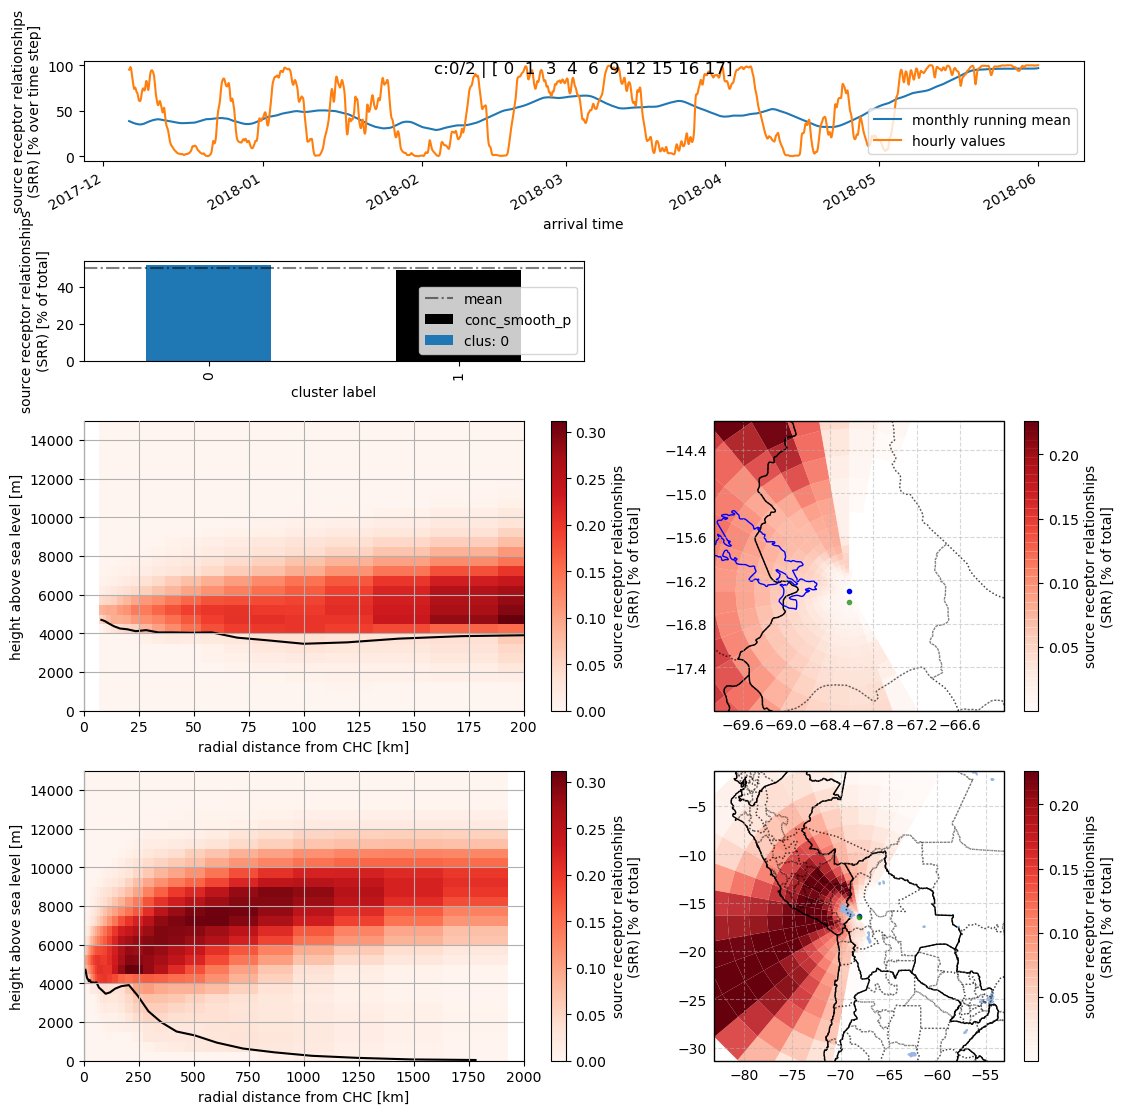

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


[ 3  4  9 12 15]
[ 2  7  8 10 14]
[ 1  5 13 16]
[ 0  6 11 17]
{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


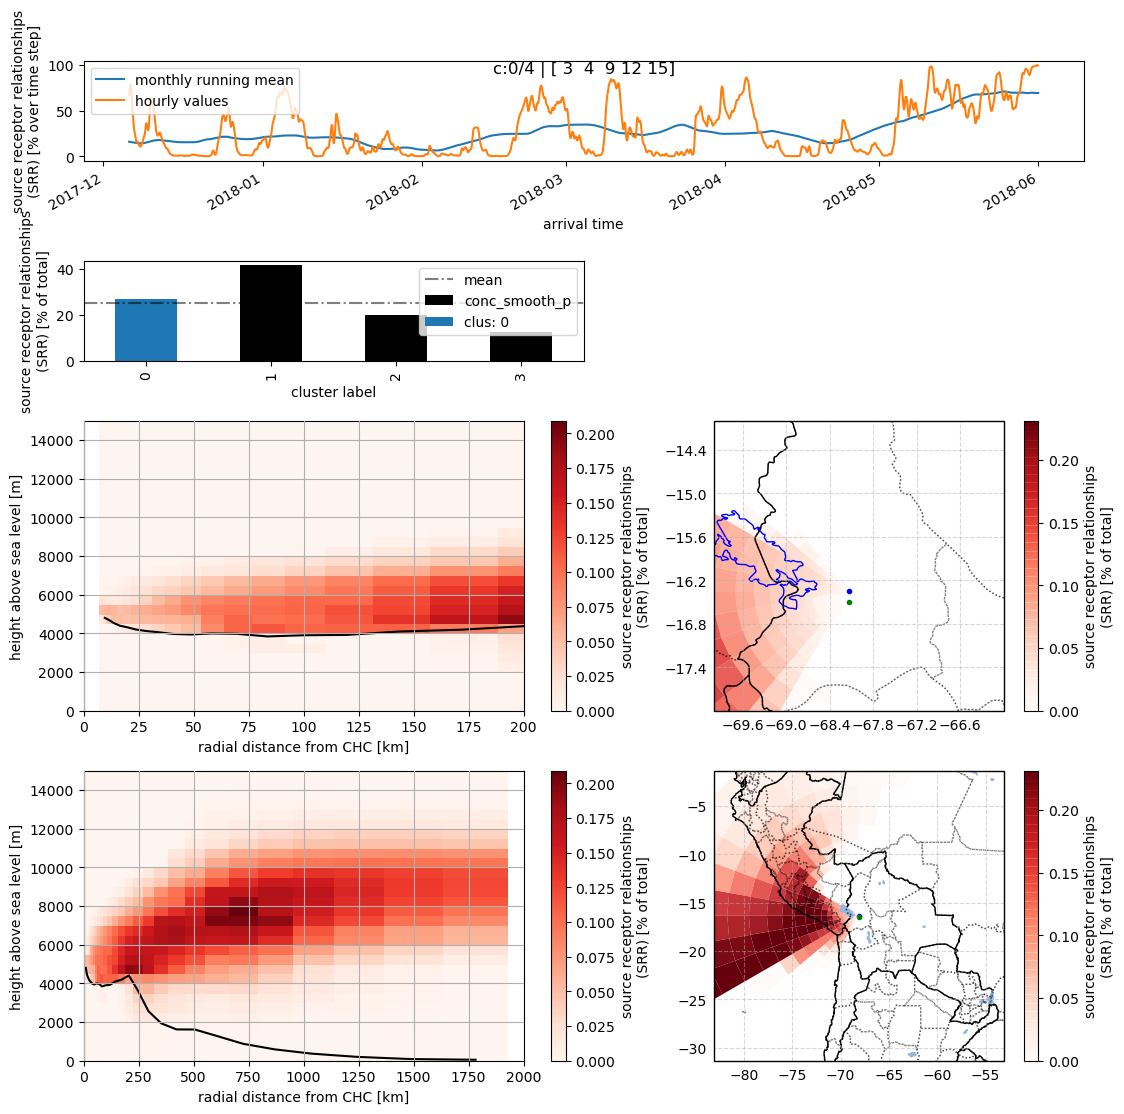

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


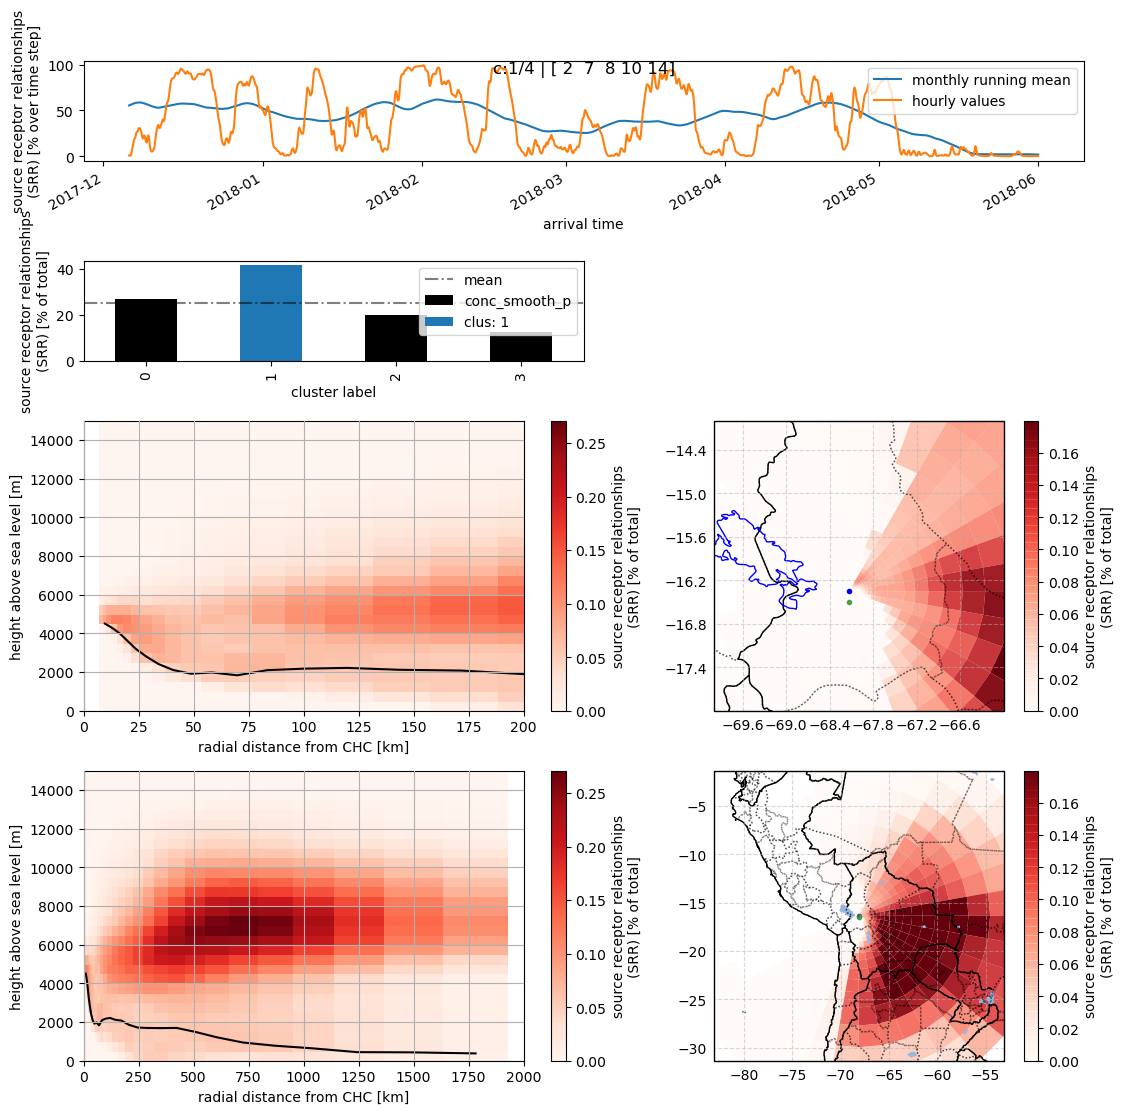

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


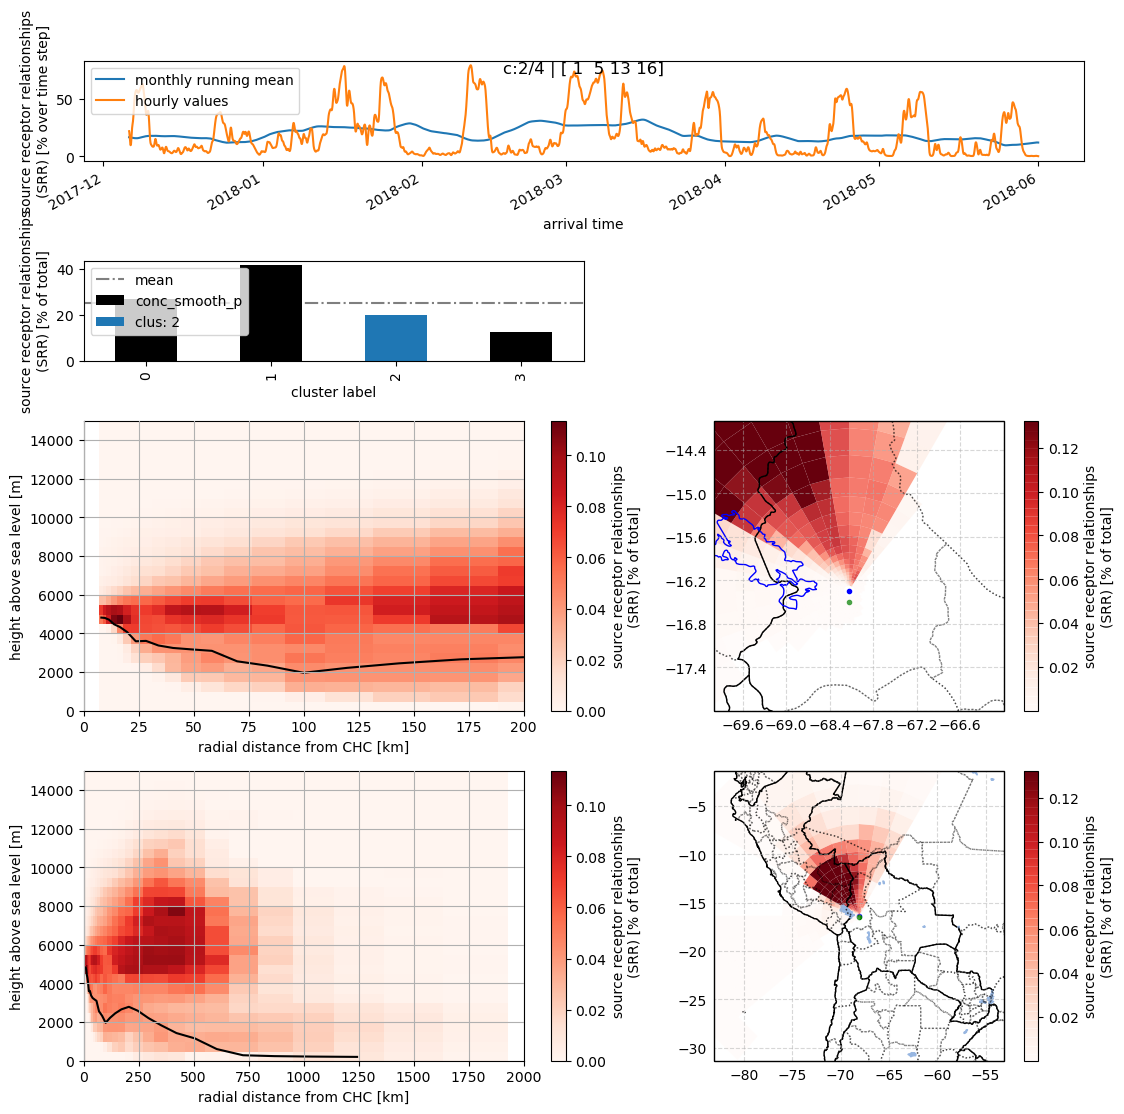

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


[ 2  5 13]
[ 3 12 15 17]
[11 14]
[ 1  9 16]
[0 4 6]
[ 7  8 10]
{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


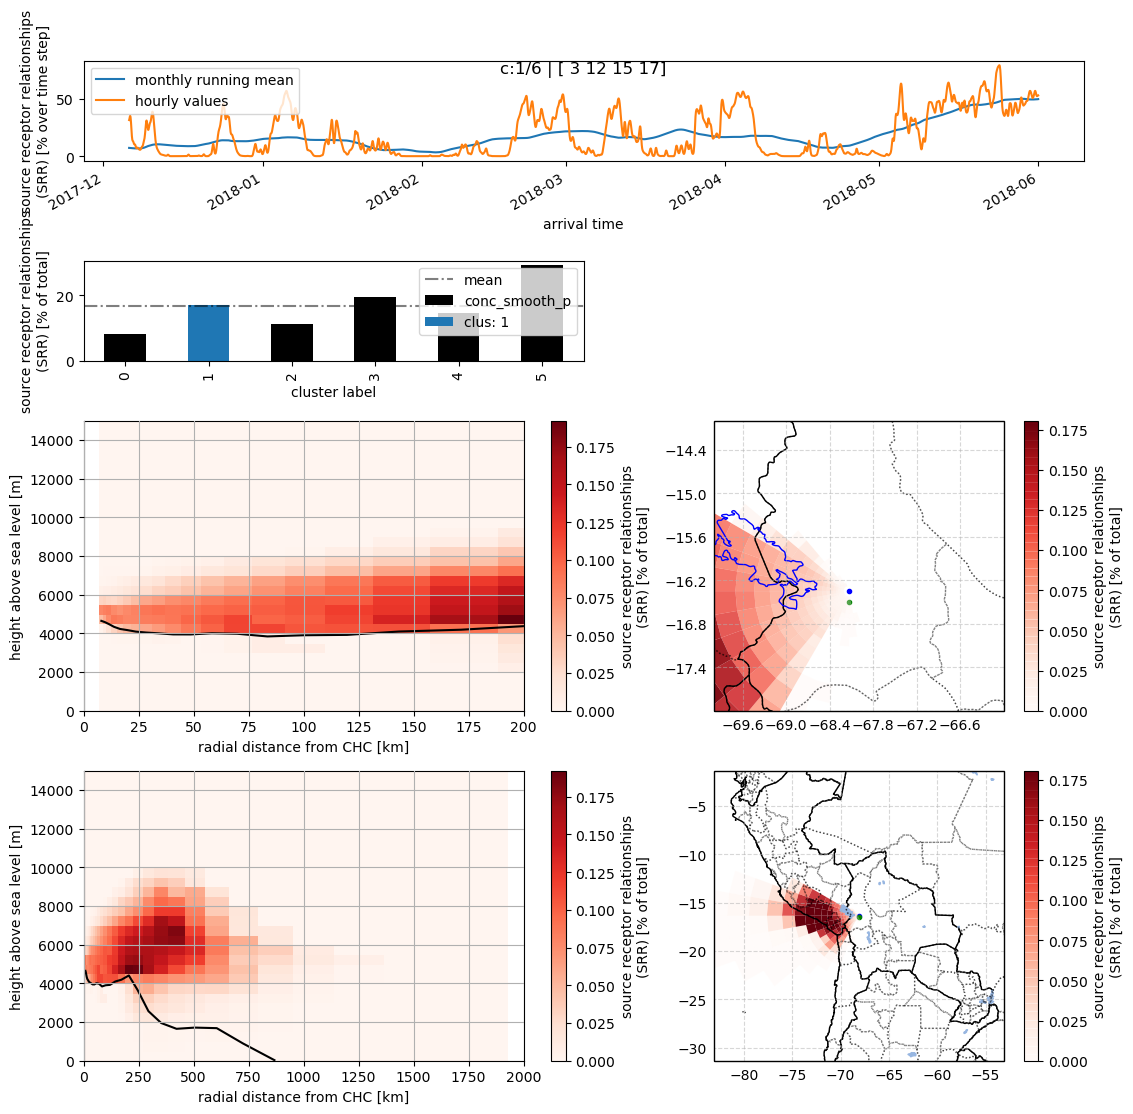

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


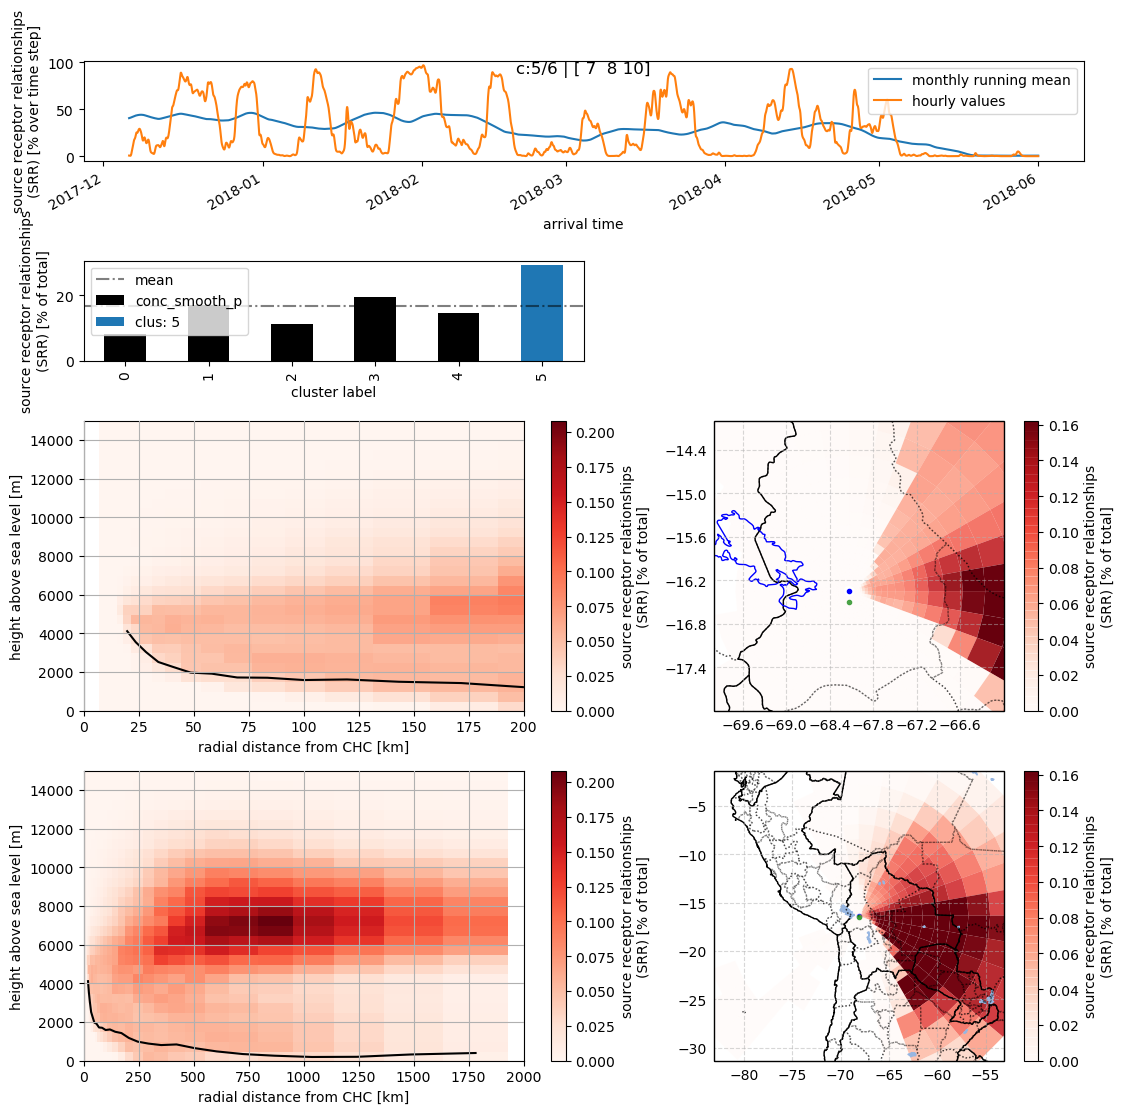

[1 9]
[ 2 10]
[0]
[ 6 12 17]
[ 5 13 16]
[ 8 11 14]
[ 3  4 15]
[7]
{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


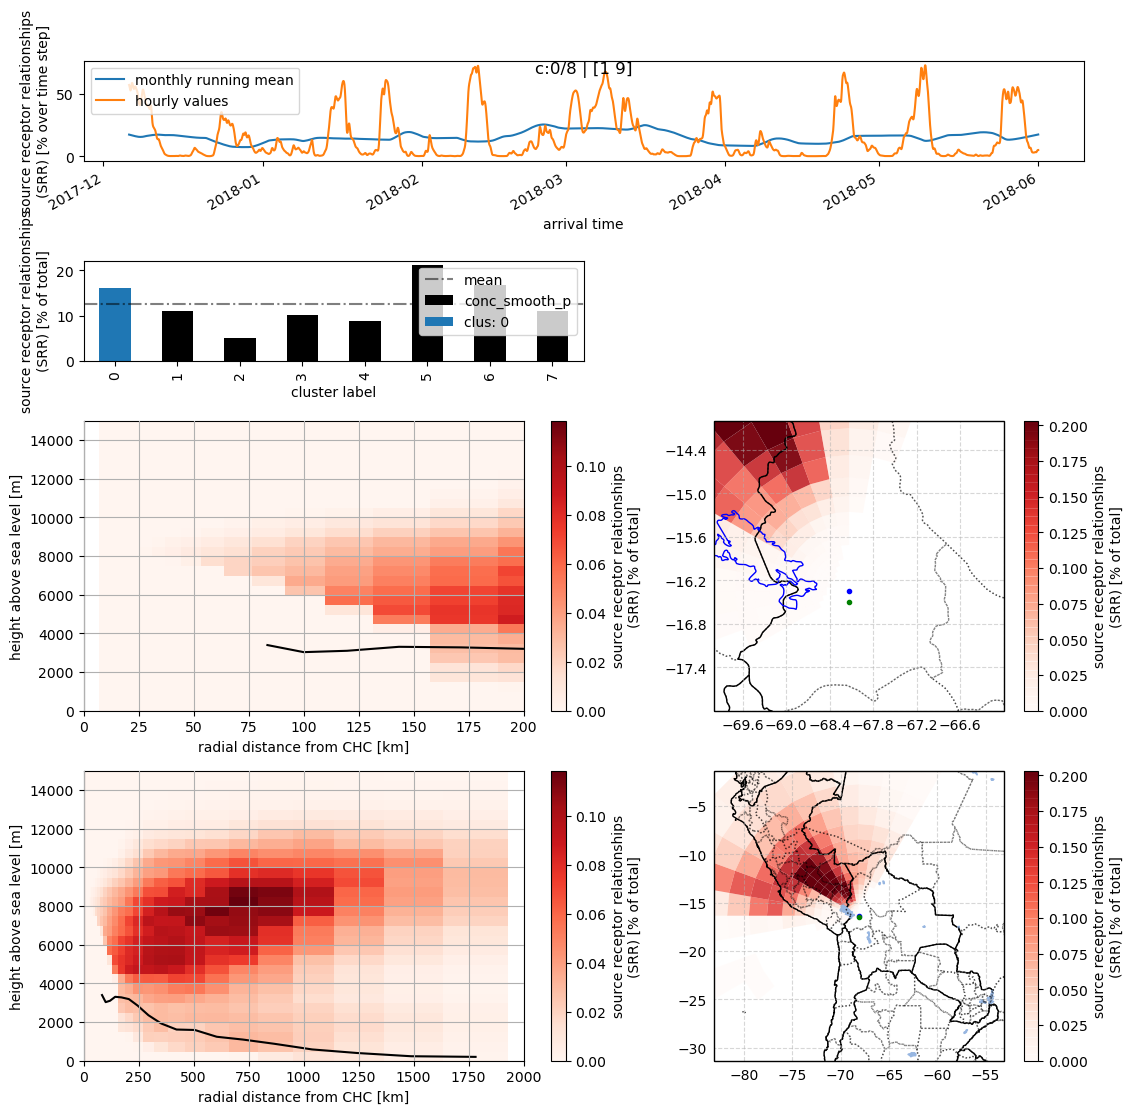

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


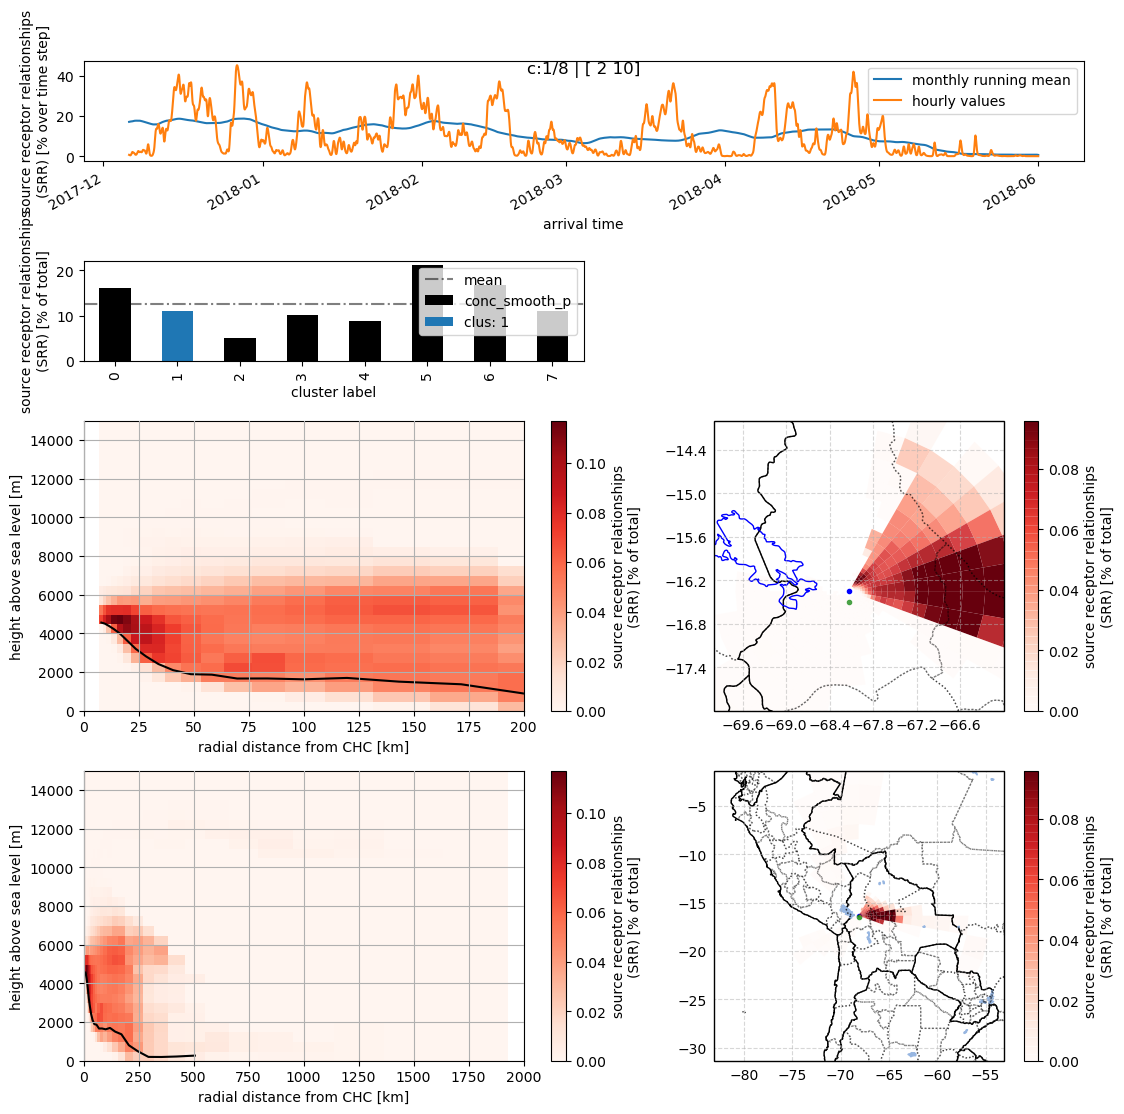

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


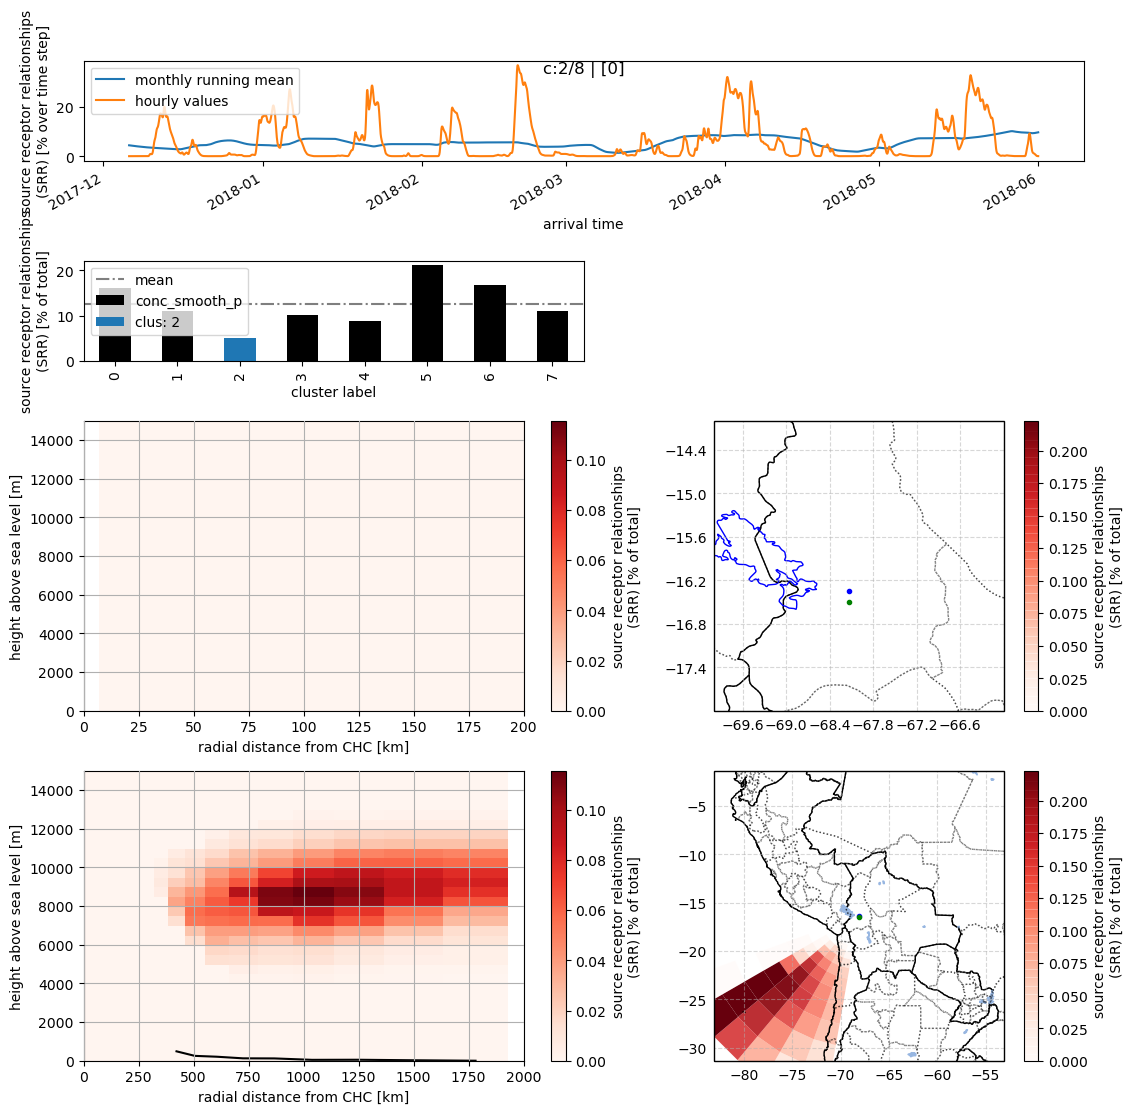

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


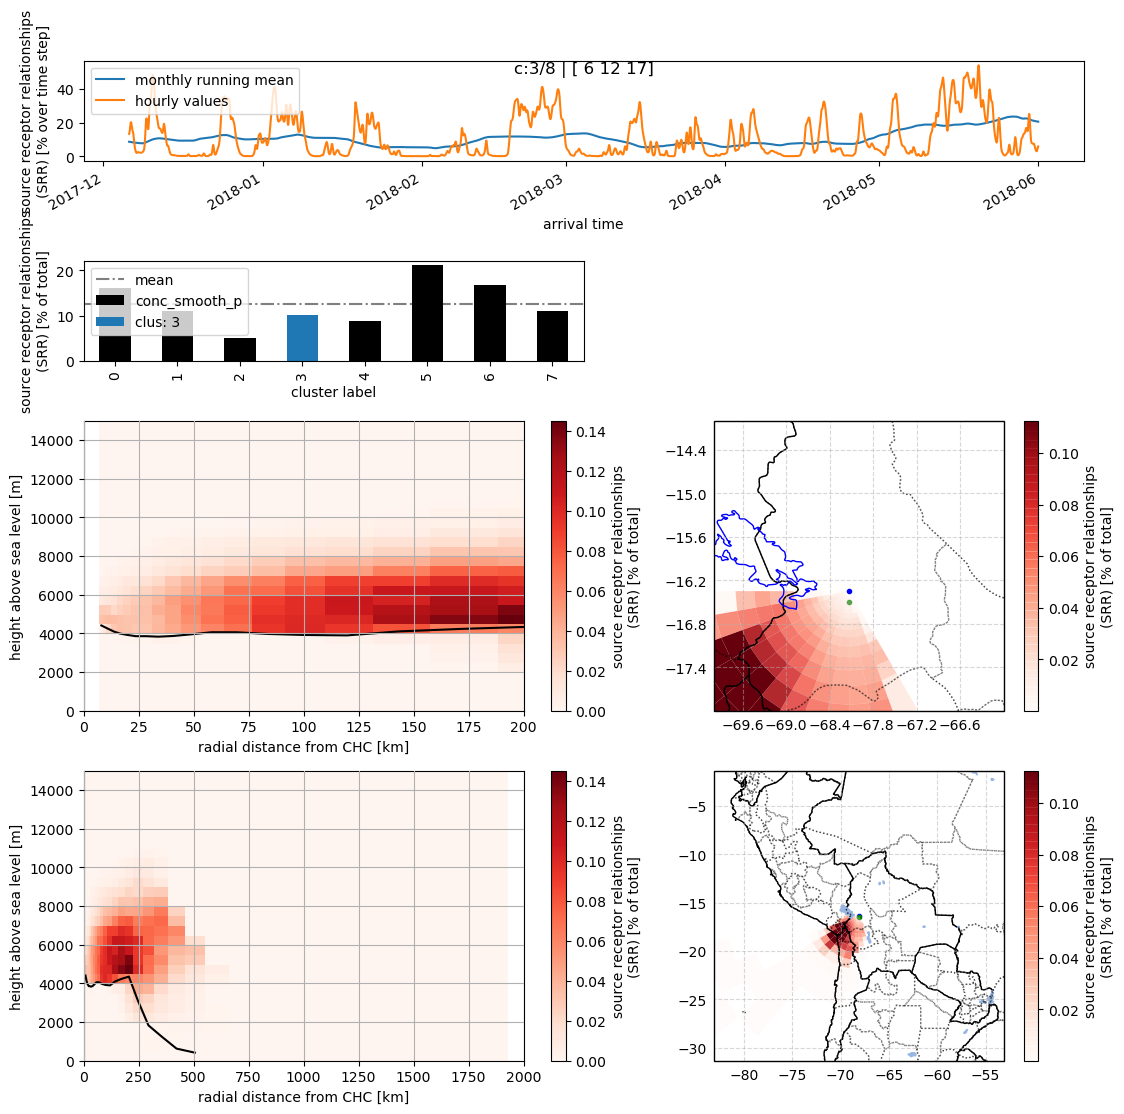

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


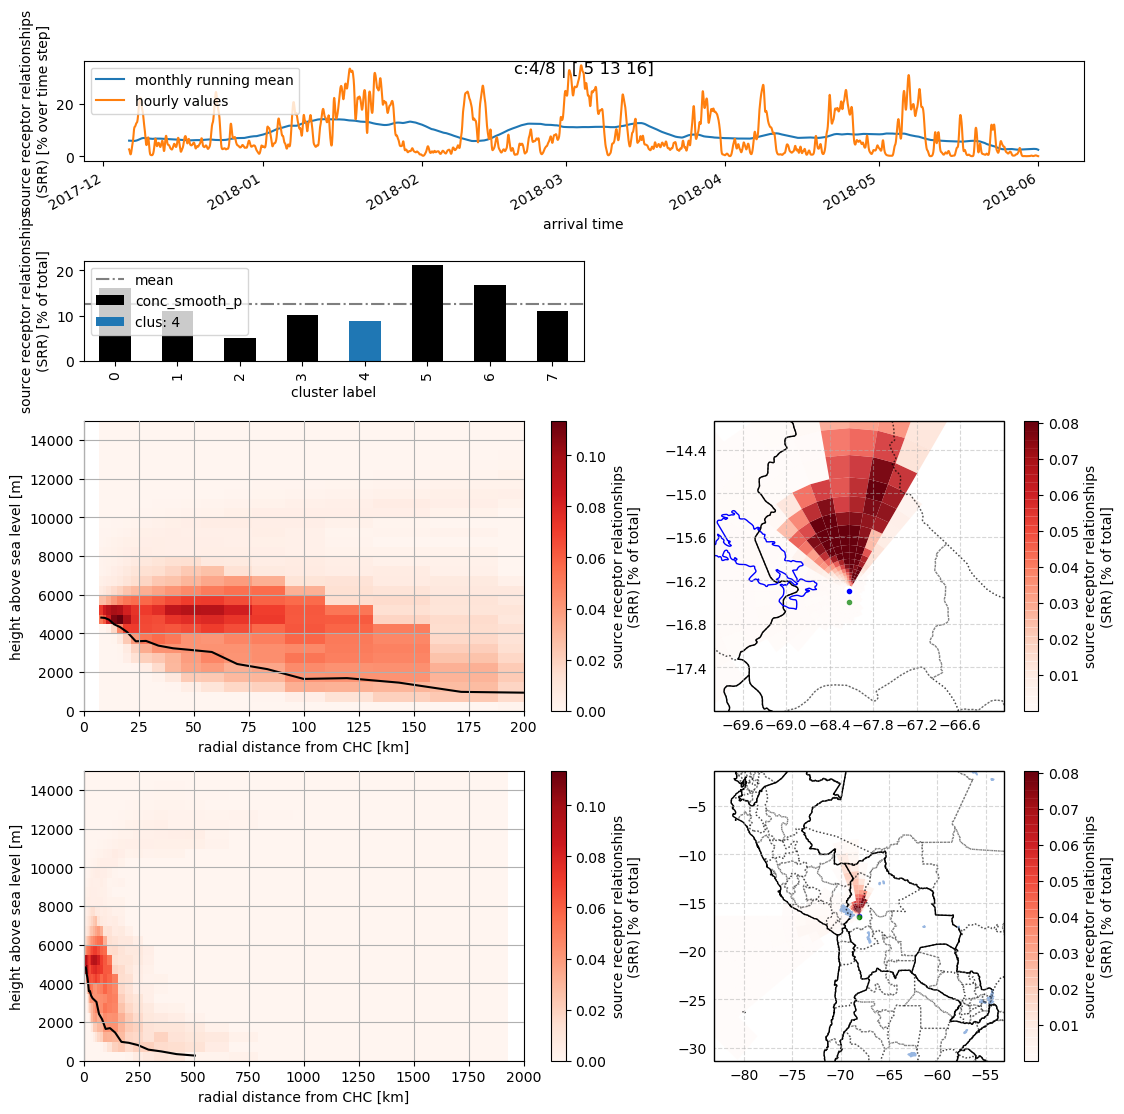

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


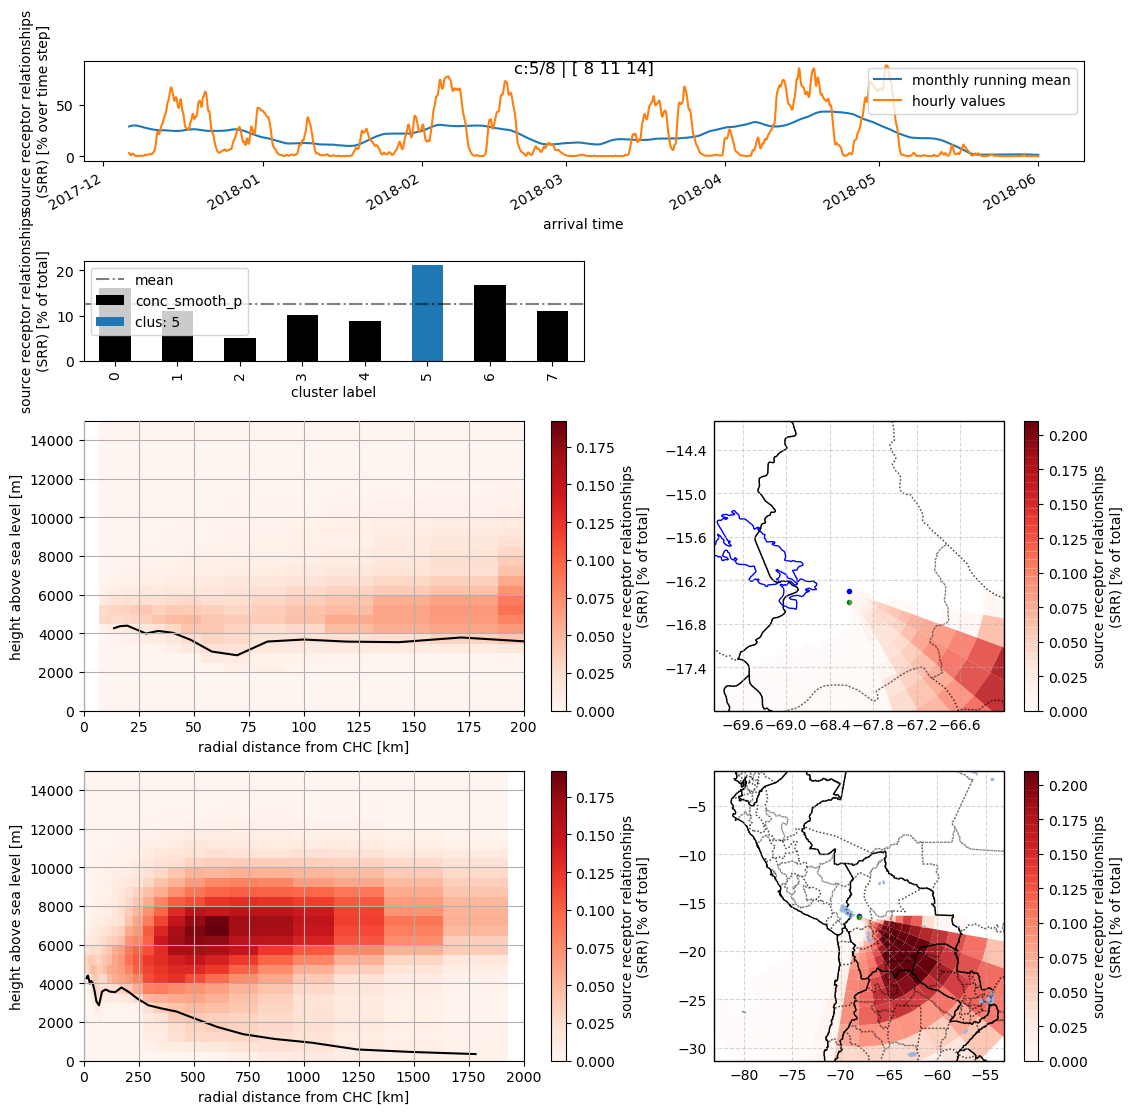

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


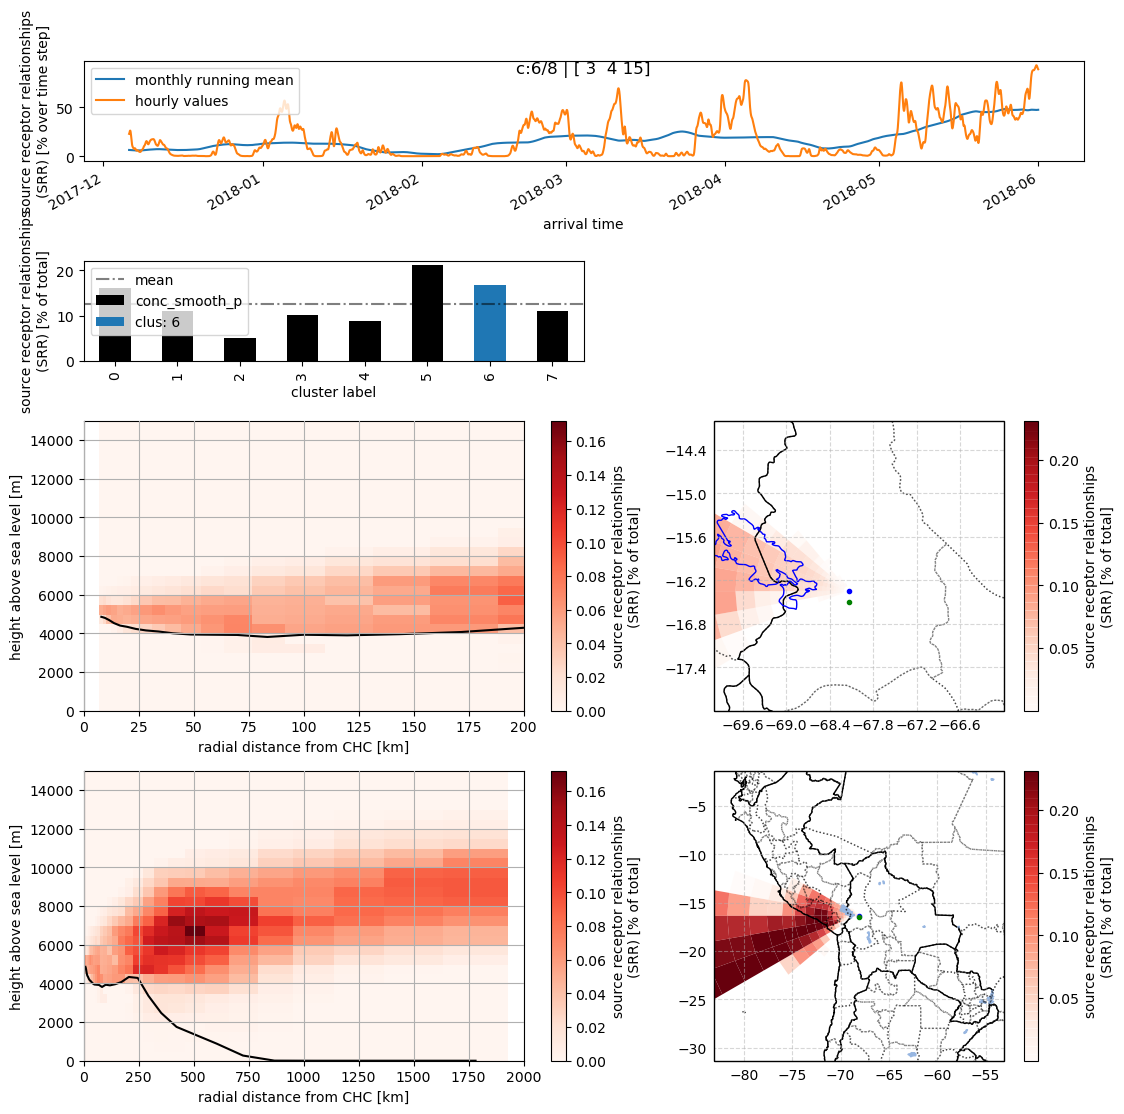

{'long_name': 'source receptor relationships (SRR)', 'total': 1336599876.6291237, 'units': '% of total'}
-90.0


/Users/diego/flexpart_management/flexpart_management/modules/clustering_funs.py:1104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


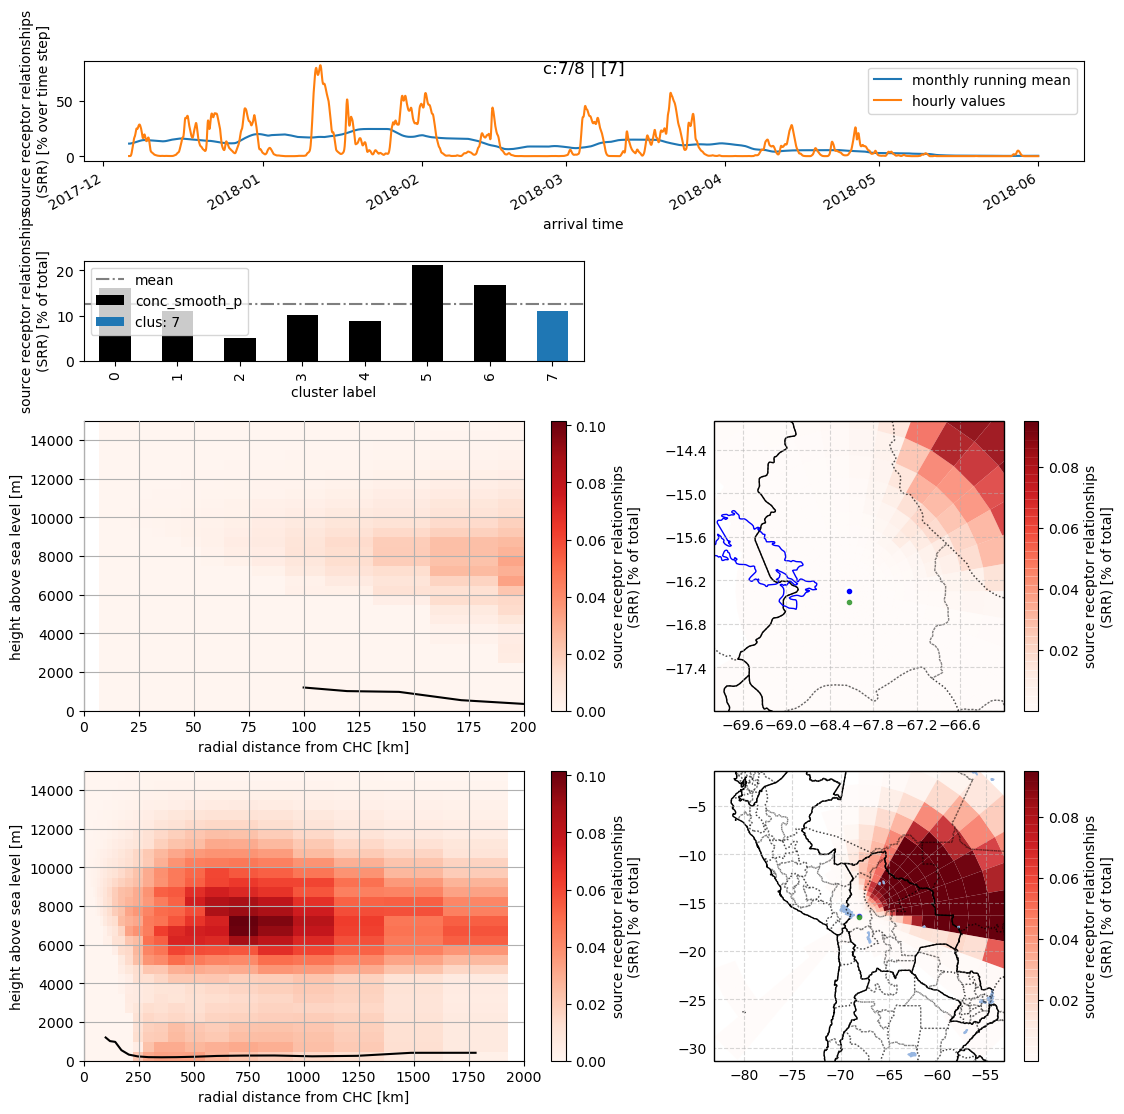

In [51]:

for meta_cluster_i in meta_cluster_list :
    # ds_re_lab = ds.copy()
    ds_re_lab = get_re_lab_ds( ds=ds , ds_sum=ds_sum , df_labs=df_labs ,
                               meta_cluster_i=meta_cluster_i )
    for current_i in range( meta_cluster_i ) :
        # re_lab_ds( meta_cluster_i , current_i , df_labs , ds_sum )

        title = get_ds_re_lab_title( current_i , df_labs , meta_cluster_i )

        cfuns.clus_plot(
            ds=ds_re_lab , i_lab=current_i ,
            conc_lab=new_lab_p ,
            conc_lab_ts=new_lab_p_t,
            dpi=100 ,
            figure_size=10 ,
            fig_title=title,

            )

        plt.show()


